# ***Version 02***
  - v02: Added Data Augmentation to prevent overfitting
  - v01: Initial base model

---



*   Topic:
    Deepfake Detection with Images
*   Models:
    XceptionNet, EfficientNet-B0
*   Developement Environment:
  1.   Google Colab
  2.   Tesla T4 GPU
  3.   PyTorch
*   Dataset: https://www.kaggle.com/datasets/shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset?resource=download
*   Research Questions
  1.   How does the architectural difference between EfficientNet-B0 and XceptionNet influence their performance in detecting deepfake images?
  2.   Which model, EfficientNet-B0 or XceptionNet, demonstrates higher accuracy and computational efficiency in detecting deepfake images?
  3.   How does data augmentation impact the performance of deepfake image detection models trained on imbalanced datasets?
  4.   How do the Grad-CAM visualizations of each model, as an Explainable AI (XAI) technique, differ in terms of feature extraction for deepfake detection?
  






In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Install Packages

In [ ]:
!pip install efficientnet_pytorch # For EfficientNet
!pip install timm # For XceptionNet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=19954d35b322130666203f012860a29f09b79155ca3e70b09

# 2. Import Libraries

In [ ]:
#import sys
#print(sys.version)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import os
import shutil
import random
import time
import seaborn as sns
import numpy as np

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from glob import glob
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc


# 3. Prepare Models (XceptionNet and EfficientNet-B0)

In [ ]:
model_xception = timm.create_model('xception', pretrained=True, num_classes=2)
model_efficient = EfficientNet.from_pretrained('efficientnet-b0')
model_efficient._fc = nn.Linear(model_efficient._fc.in_features, 2)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 205MB/s]

Loaded pretrained weights for efficientnet-b0


# 4. Split the data into 80% training, 10% validation and 10% test

In [ ]:
# Path for image folder
base_dir = '/content/drive/MyDrive/datasets/deepfake'
output_dir = '/content/drive/MyDrive/datasets/deepfake/split_dataset'

# Split real/AI dataset
classes = ['AI', 'real']
train_ratio = 0.8
validation_ratio = 0.1

for cls in classes:
    img_paths = glob(os.path.join(base_dir, cls, '*'))
    total_count = len(img_paths)
    random.shuffle(img_paths)

    train_end = int(total_count * train_ratio)
    validation_end = train_end + int(total_count * validation_ratio)

    train_imgs = img_paths[:train_end]
    validation_imgs = img_paths[train_end:validation_end]
    test_imgs = img_paths[validation_end:]

    # make directory
    for phase in ['train', 'validation', 'test']:
        target_dir = os.path.join(output_dir, phase, cls)
        os.makedirs(target_dir, exist_ok=True)

    # copy images
    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(output_dir, 'train', cls))

    for img_path in validation_imgs:
        shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))

    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

    # print the number of images after splitting
    print(f"[{cls}] Total number of images: {total_count}")
    print(f"[{cls}] Number of training images: {len(train_imgs)}")
    print(f"[{cls}] Number of validation images: {len(validation_imgs)}")
    print(f"[{cls}] Number of test images: {len(test_imgs)}")
    print('-' * 40)

print("Image split and copy completed.")


[AI] Total number of images: 1000
[AI] Number of training images: 800
[AI] Number of validation images: 100
[AI] Number of test images: 100
----------------------------------------
[real] Total number of images: 2202
[real] Number of training images: 1761
[real] Number of validation images: 220
[real] Number of test images: 221
----------------------------------------
Image split and copy completed.


# 5. Dataset Preprocessing and Loading

In [ ]:
#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
#])

# Data Augmentation (to prevent overfitting)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Horizontal flip
    transforms.RandomRotation(20),         # Random rotation within 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color properties
    transforms.RandomResizedCrop(224),     # Random crop and resize to 224x224
    transforms.ToTensor(),                 # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/train', transform=transform)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/validation', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# 6. Define the training function

In [ ]:
def train_model(model, train_loader, validation_loader, epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    train_precisions, train_recalls, train_f1s, train_aucs = [], [], [], []
    val_precisions, val_recalls, val_f1s, val_aucs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        all_train_preds = []
        all_train_labels = []

        # Train
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

            all_train_preds.extend(outputs.argmax(1).cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_accuracy = correct / len(train_loader.dataset)
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_auc = roc_auc_score(all_train_labels, all_train_preds)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

                all_val_preds.extend(outputs.argmax(1).cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_accuracy = val_correct / len(validation_loader.dataset)
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_auc = roc_auc_score(all_val_labels, all_val_preds)

        #
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss / len(validation_loader))
        val_accuracies.append(val_accuracy)

        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        train_aucs.append(train_auc)

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        print(f"Epoch {epoch+1}: Train Loss={running_loss:.4f}, Acc={train_accuracy:.4f} | " f"Val Loss={val_loss:.4f}, Acc={val_accuracy:.4f}")

    # Metrics Graphs
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions,
                 train_recalls, val_recalls,
                 train_f1s, val_f1s,
                 train_aucs, val_aucs)

# 7. Define the evaluation fuction

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    y_probs = []  # Store probabilities for ROC curve

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)

            # Convert logits to probabilities
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(1).cpu()

            y_pred.extend(preds.numpy())
            y_true.extend(labels.numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class '1' (AI)

    # Print classification report (precision, recall, F1-score)
    print(classification_report(y_true, y_pred, target_names=['real', 'AI']))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'AI'], yticklabels=['real', 'AI'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# 8.Make metrics/graphs

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions,
                 train_recalls, val_recalls,
                 train_f1s, val_f1s,
                 train_aucs, val_aucs):
    # Loss
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(3, 2, 3)
    plt.plot(train_precisions, label='Train')
    plt.plot(val_precisions, label='Validation')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(3, 2, 4)
    plt.plot(train_recalls, label='Train')
    plt.plot(val_recalls, label='Validation')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # F1-Score
    plt.subplot(3, 2, 5)
    plt.plot(train_f1s, label='Train')
    plt.plot(val_f1s, label='Validation')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # AUC
    plt.subplot(3, 2, 6)
    plt.plot(train_aucs, label='Train')
    plt.plot(val_aucs, label='Validation')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9. Set up device (GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 10-1. Train XceptionNet

Training XceptionNet...
----------------------------------------
Epoch 1: Train Loss=19.3381, Acc=0.9672 | Val Loss=0.1010, Acc=1.0000
Epoch 2: Train Loss=3.2363, Acc=0.9938 | Val Loss=0.0267, Acc=1.0000
Epoch 3: Train Loss=5.1766, Acc=0.9953 | Val Loss=0.0205, Acc=1.0000
Epoch 4: Train Loss=1.5218, Acc=0.9984 | Val Loss=0.0197, Acc=1.0000
Epoch 5: Train Loss=2.2334, Acc=0.9977 | Val Loss=0.3732, Acc=1.0000
Epoch 6: Train Loss=2.1613, Acc=0.9977 | Val Loss=0.0512, Acc=1.0000
Epoch 7: Train Loss=1.6258, Acc=0.9977 | Val Loss=0.0529, Acc=0.9969
Epoch 8: Train Loss=1.0680, Acc=0.9996 | Val Loss=0.0900, Acc=1.0000
Epoch 9: Train Loss=1.4135, Acc=0.9992 | Val Loss=0.1144, Acc=1.0000
Epoch 10: Train Loss=0.2696, Acc=1.0000 | Val Loss=0.0030, Acc=1.0000


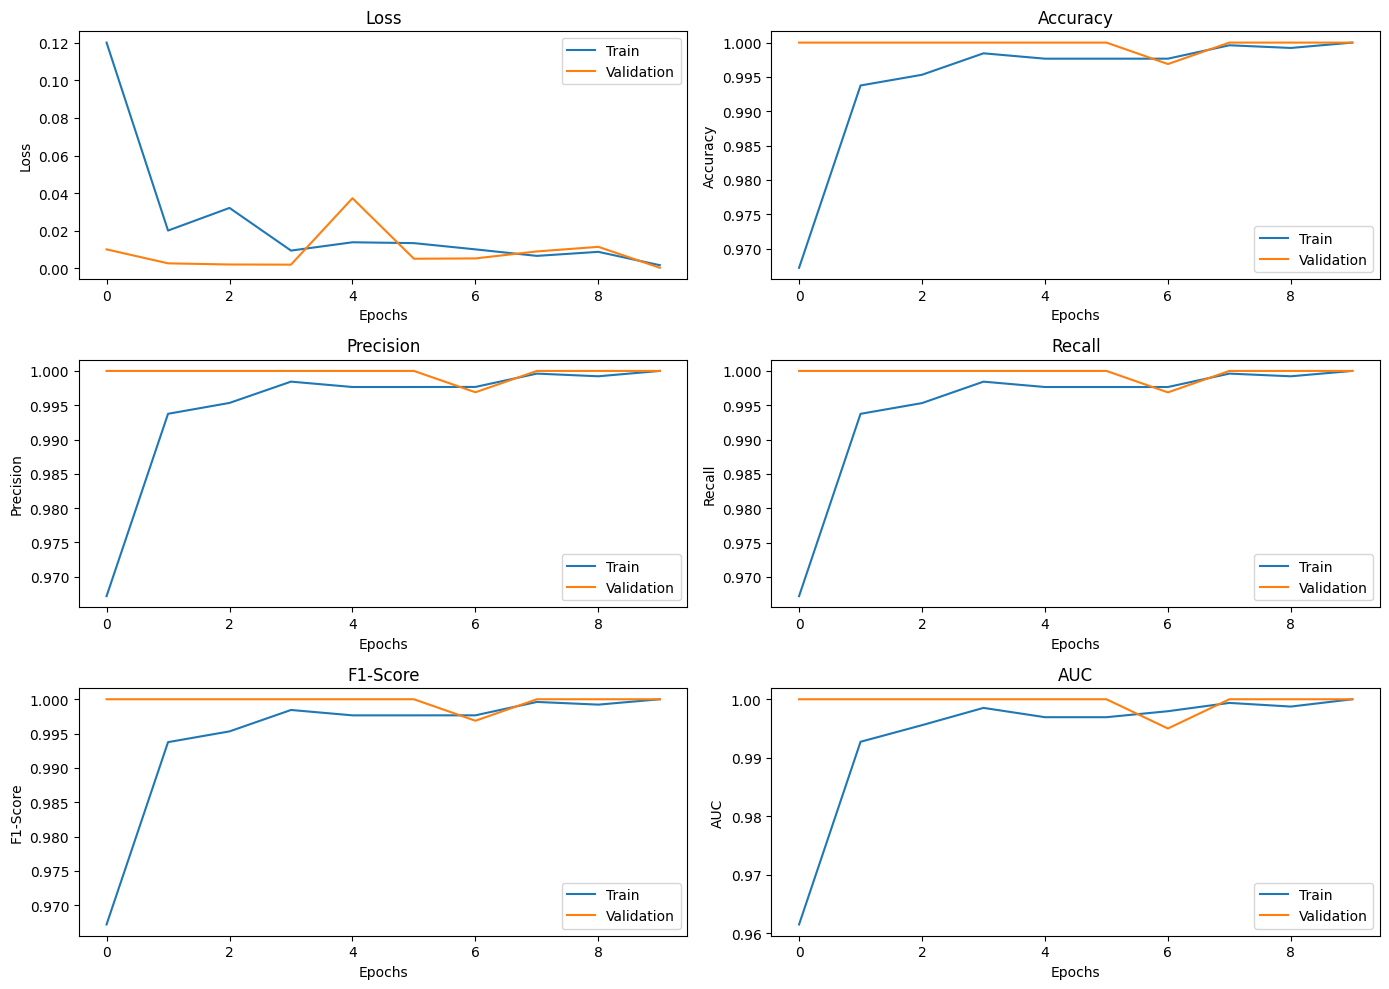

----------------------------------------
Training completed in 19.58 minutes


In [ ]:
print("Training XceptionNet...")
print('-' * 40)
start_time = time.time()

train_model(model_xception, train_loader, validation_loader, epochs=10)

end_time = time.time()
elapsed_time = end_time - start_time
print('-' * 40)
print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 10-2. Evaluate XceptionNet

              precision    recall  f1-score   support

        real       1.00      1.00      1.00       100
          AI       1.00      1.00      1.00       221

    accuracy                           1.00       321
   macro avg       1.00      1.00      1.00       321
weighted avg       1.00      1.00      1.00       321



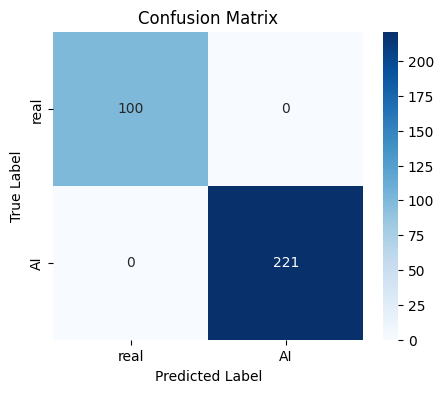

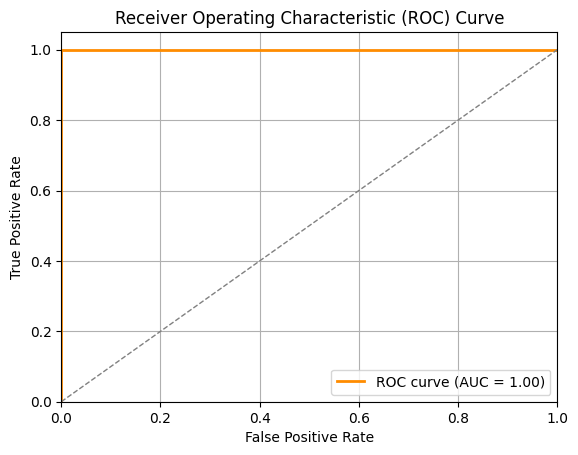

In [ ]:
evaluate_model(model_xception, test_loader)

# 11-1. Train EfficientNet-B0

Training EfficientNet-B0...
Epoch 1: Train Loss=26.2153, Acc=0.9551 | Val Loss=0.2773, Acc=0.9938
Epoch 2: Train Loss=7.5123, Acc=0.9910 | Val Loss=0.0464, Acc=1.0000
Epoch 3: Train Loss=5.3095, Acc=0.9945 | Val Loss=0.0164, Acc=1.0000
Epoch 4: Train Loss=4.2701, Acc=0.9941 | Val Loss=0.0110, Acc=1.0000
Epoch 5: Train Loss=4.1422, Acc=0.9949 | Val Loss=0.0246, Acc=1.0000
Epoch 6: Train Loss=2.0472, Acc=0.9965 | Val Loss=0.0113, Acc=1.0000
Epoch 7: Train Loss=1.2540, Acc=0.9984 | Val Loss=0.0171, Acc=1.0000
Epoch 8: Train Loss=3.4369, Acc=0.9957 | Val Loss=0.0157, Acc=1.0000
Epoch 9: Train Loss=1.1674, Acc=0.9992 | Val Loss=0.0059, Acc=1.0000
Epoch 10: Train Loss=0.7993, Acc=0.9980 | Val Loss=0.0190, Acc=1.0000


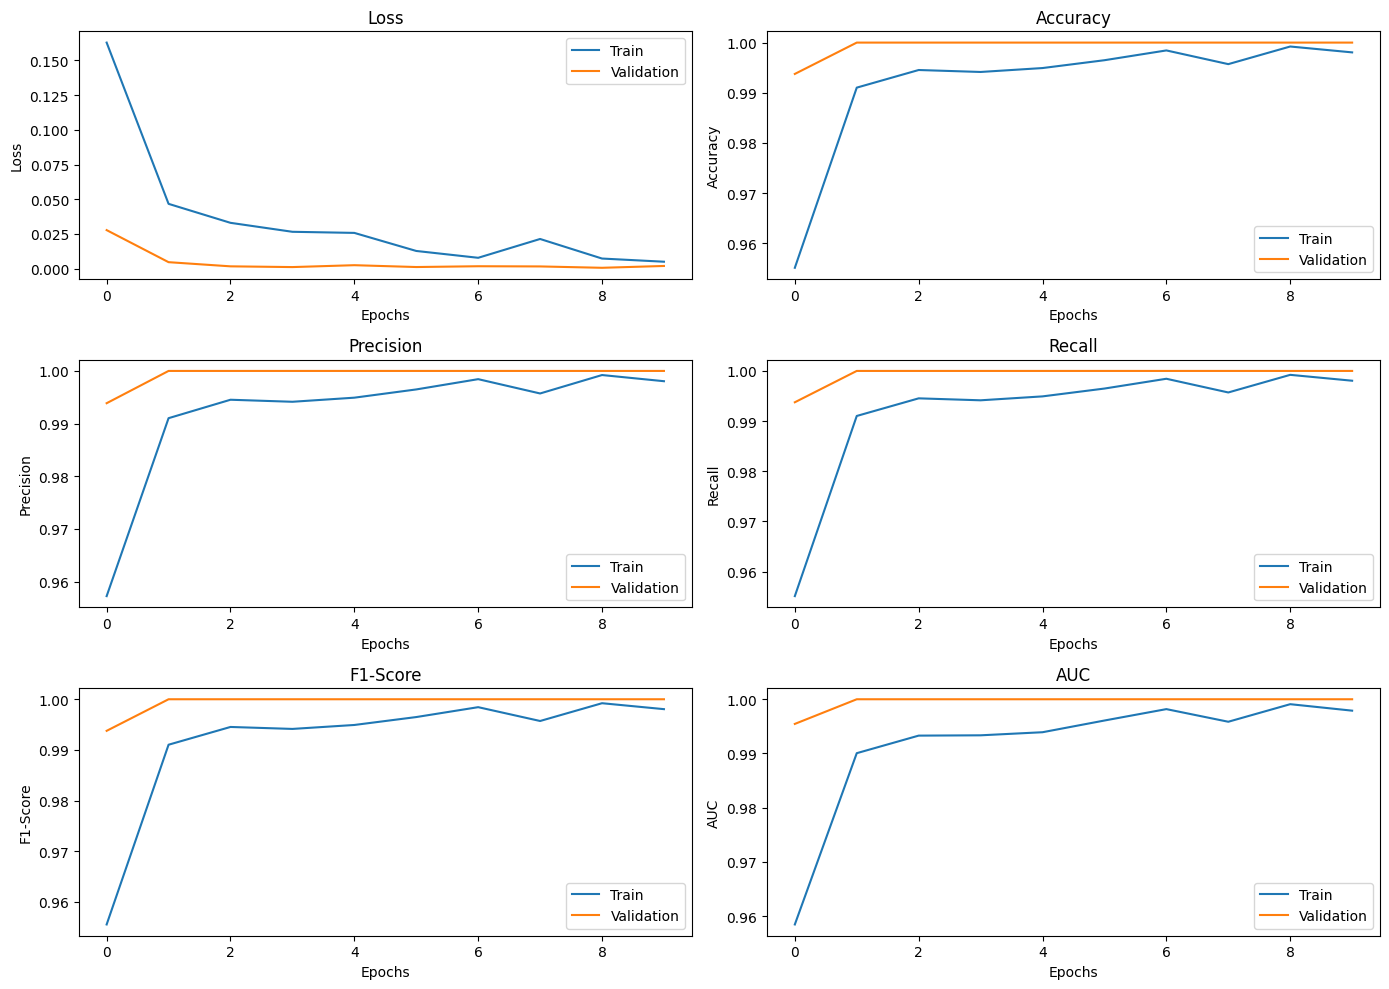

Training completed in 12.64 minutes


In [ ]:
print("Training EfficientNet-B0...")
print('=' * 40)
start_time = time.time()

train_model(model_efficient, train_loader, validation_loader, epochs=10)

end_time = time.time()
elapsed_time = end_time - start_time
print('=' * 40)
print(f"Training completed in {elapsed_time / 60:.2f} minutes")



# 11-2. Evaluate EfficientNet-B0

              precision    recall  f1-score   support

        real       1.00      0.99      0.99       100
          AI       1.00      1.00      1.00       221

    accuracy                           1.00       321
   macro avg       1.00      0.99      1.00       321
weighted avg       1.00      1.00      1.00       321



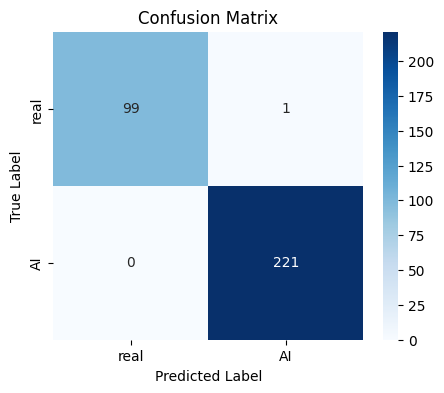

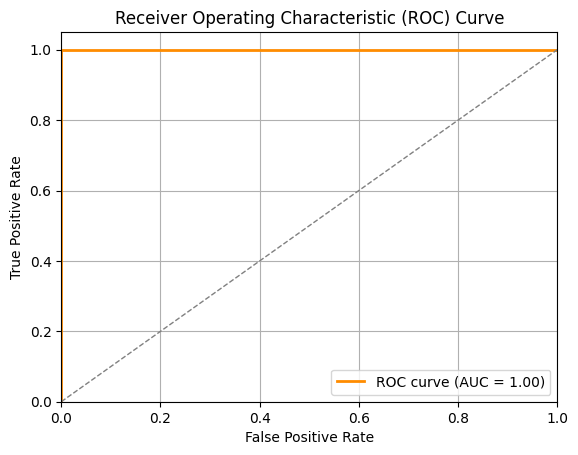

In [ ]:
evaluate_model(model_efficient, test_loader)